In [524]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

## Utils

In [574]:
def read_pdb(filename):

    with open(filename, 'r') as file:
        strline_L = file.readlines()
        # print(strline_L)

    X_list = list()
    Y_list = list()
    Z_list = list()
    atomtype_list = list()
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()

        line_length = len(stripped_line)
        # print("Line length:{}".format(line_length))
        if line_length < 78:
            print("ERROR: line length is different. Expected>=78, current={}".format(line_length))

        X_list.append(float(stripped_line[30:38].strip()))
        Y_list.append(float(stripped_line[38:46].strip()))
        Z_list.append(float(stripped_line[46:54].strip()))

        atomtype = stripped_line[76:78].strip()
        if atomtype == 'C':
            atomtype_list.append('h') # 'h' means hydrophobic
        else:
            atomtype_list.append('p') # 'p' means polar

    return X_list, Y_list, Z_list, atomtype_list


X_list, Y_list, Z_list, atomtype_list=read_pdb(r"D:\CS\NTU\BS6207\project\training_data\training_data/2060_lig_cg.pdb")
# X_list, Y_list, Z_list, atomtype_list=read_pdb("training_first_100_samples/0001_pro_cg.pdb")
# X_list, Y_list, Z_list, atomtype_list=read_pdb("training_first_100_samples/0001_lig_cg.pdb")
print(X_list)
print(Y_list)
print(Z_list)
print(atomtype_list)


[-5.749, -4.952, -3.006, -4.678]
[1.335, 3.684, 7.021, 2.079]
[16.839, 13.851, 13.268, 12.118]
['p', 'h', 'p', 'h']


### consider the feature x,y,z and atom type as image pixel
#### collect data features and coordinates

In [316]:
str_num=[]
for i in range(1,3001):
    index=(4-len(str(i)))*'0'+str(i)     
    str_num.append(index)

pos_data_set=[]
neg_data_set=[]
for i in str_num:
    for j in str_num:
        if i==j:
            pos_data_set.append((i,j))
        else:
            neg_data_set.append((i,j))

In [450]:
#lig-dataset
lig_data_set=dict()
for i in str_num:
    path=r"D:\CS\NTU\BS6207\project\training_data\training_data\{}_lig_cg.pdb".format(i)
    X,Y,Z,atom_types=read_pdb(path)
    one_image=[]
    for x,y,z,atom_type in zip(X,Y,Z,atom_types):
        if atom_type=='p':
            pixel=np.array([x,y,z,1,0,-1])
        else:
            pixel=np.array([x,y,z,0,1,-1])
        one_image.append(pixel)
    lig_data_set[i]=np.stack(one_image,axis=0)

In [452]:
lig_data_set["0003"]

array([[ 3.308, 10.315, 25.119,  0.   ,  1.   , -1.   ],
       [ 5.761,  7.669, 23.663,  1.   ,  0.   , -1.   ],
       [ 6.614,  3.592, 20.328,  0.   ,  1.   , -1.   ],
       [ 9.714,  1.305, 18.22 ,  0.   ,  1.   , -1.   ],
       [ 9.77 ,  7.655, 26.167,  0.   ,  1.   , -1.   ],
       [14.336,  7.5  , 26.728,  1.   ,  0.   , -1.   ]])

In [457]:
# protein dataset
pro_data_set=dict()
for i in str_num:
    path=r"D:\CS\NTU\BS6207\project\training_data\training_data/{}_pro_cg.pdb".format(i)
    X,Y,Z,atom_types=read_pdb(path)
    one_image=[]
    for x,y,z,atom_type in zip(X,Y,Z,atom_types):
        if atom_type=='p':
            pixel=np.array([x,y,z,1,0,1])
        else:
            pixel=np.array([x,y,z,0,1,1])
        one_image.append(pixel)
    pro_data_set[i]=np.stack(one_image,axis=0)

In [458]:
pro_data_set['0003'].shape

(584, 6)

#### generate positive and negative items

In [319]:
len(neg_data_set)

8997000

In [321]:
random.shuffle(pos_data_set)
random.shuffle(neg_data_set)

train_pos_data=pos_data_set[:int(0.8*len(pos_data_set))]
train_neg_data=neg_data_set[:int(0.8*len(neg_data_set))]

valid_pos_data=pos_data_set[int(0.8*len(pos_data_set)):]
valid_neg_data=neg_data_set[int(0.8*len(pos_data_set)):]

In [322]:
len(train_pos_data)

2400

In [324]:
#

#### utils method

In [786]:
import math
from math import pi
# from itertools import combinations
import torch.utils.data as data
import math
import random
import torch
from torch import nn
import torchvision.transforms as transform

def cal_center(data_array):
    coord=data_array[:,:3]
#     print(np.mean(coord,axis=0))
    return np.mean(coord,axis=0)

def change(data_set,max_dist,grid_resolution,center):
    coords=data_set[:,:3]
    features=data_set[:,3:]
    max_dist = float(max_dist)
    grid_resolution = float(grid_resolution)
    # transform coordinate into the coordinate whose center is the center we set instead of (0,0,0)
            
    coords=coords-center
#             print(coords)
    box_size = math.ceil(2 * max_dist / grid_resolution + 1)

    # move all atoms to the neares grid point
    grid_coords = (coords + max_dist) / grid_resolution
    grid_coords = np.round(grid_coords).astype(int)
        #     print(grid_coords)
            # remove atoms outside the box
    in_box = ((grid_coords >= 0) & (grid_coords < box_size)).all(axis=1)
        #     print("check")
        #     print(features[in_box])
    grid = np.zeros((box_size, box_size, box_size, features.shape[1]))
    for (x, y, z), f in zip(grid_coords[in_box], features[in_box]):
        grid[x, y, z] += f
    grid=grid.swapaxes(0,-1) # C,X change
    grid=grid.swapaxes(1,-1) # Y,X change
    grid=grid.swapaxes(2,-1) #，Z，Y changge,    #final grid shape(C,X,Y,Z)

#     print('grid shape',grid.shape)
    return grid

class rotation_grid():

    def __init__(self,axis=None):
        self.axis = axis
    
    def __call__(self,sample):
        pro,lig=sample
        if self.axis is None:
            self.axis = np.random.uniform(size=(3,))
        else:
            self.axis = np.asarray(self.axis)
    
        theta= np.random.rand()* 2 * math.pi 
        self.axis = self.axis / np.sqrt(np.dot(self.axis, self.axis))
        a = np.cos(theta / 2.0)
        b, c, d = -self.axis * np.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        rot=np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
        
        new_axis_pro=np.dot(rot,pro[:,:3].T)
        new_axis_lig=np.dot(rot,lig[:,:3].T)
        return (np.hstack((new_axis_pro.T,pro[:,3:])),np.hstack((new_axis_lig.T,lig[:,3:])))

class make_grid():
    def __init__(self,grid_resolution=1.0,max_dist=10.0):
        self.grid_resolution=grid_resolution
        self.max_dist=max_dist
    def __call__(self,sample):
        pro,lig=sample
#         print('pro',pro)
#         print("_"*10)
        center=cal_center(lig)
        grid_pro=change(pro,self.max_dist,self.grid_resolution,center)
        grid_lig=change(lig,self.max_dist,self.grid_resolution,center)
        pro_lig=np.concatenate((grid_pro,grid_lig),axis=0)
#         print("pro_lig shape is ",pro_lig.shape)
        
        return pro_lig


class miniDataset(data.Dataset):
    
    def __init__(self, dataset,length,mode='training', format='array', transform=None, target_transform=None):
        self.dataset = dataset
        len_total=len(dataset)
        print(len_total)
        self.target=np.array([1]*length+[0]*(len_total-length))
#         print(len(self.target))
#         print(self.target[599])
#         print(self.target[600])
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        self.format = format

    def __getitem__(self, index):
        pro, lig = self.dataset[index][0], self.dataset[index][1]
        target=np.array(self.target[index])
#         print('dataset target:',target)
        
        if self.transform is not None:
            inp = self.transform((pro,lig))
        if self.target_transform is not None:
            target = self.target_transform(target)
            

        return inp, target

    def __len__(self):
        return len(self.dataset)
    
def create_epoch_data(train_pos_data,train_neg_data=None,pro_data_set=None,lig_data_set=None,strategy='limit'):
    train_pos_data_set=[]
    for item in train_pos_data:
#         print(pro_data_set[item[0]])
#         print(lig_data_set[item[1]])
        train_pos_data_set.append((pro_data_set[item[0]],lig_data_set[item[1]]))
    
    data_set__=train_pos_data_set
    length=len(data_set__)
    if train_neg_data is not None:
        train_neg_data_set=[]
        random.shuffle(train_neg_data)
        if strategy=='limit':
            train_neg_data__=train_neg_data[:len(train_pos_data)]

            for item in train_neg_data__:
                train_neg_data_set.append((pro_data_set[item[0]],lig_data_set[item[1]]))
        elif strategy=='all':
            for item in train_neg_data:
                train_neg_data_set.append((pro_data_set[item[0]],lig_data_set[item[1]]))
        else:
            print("Wrong strategy!")
        
        data_set__=data_set__+train_neg_data_set
    return data_set__,length

class array2tensor():
    """Convert ndarrays in sample to Tensors. Samples are assumed to be python dics"""
    def __init__(self,dtype):
        self.dtype = dtype

    def __call__(self, sample):
        return torch.from_numpy(sample).type(self.dtype)

## Model

In [438]:
class CNN(nn.Module):
    def __init__(self,dropout):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv3d(6, 64, kernel_size=3, padding=1,stride=1),  # [64, 21,21,21]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [64, 10,10,10]

            nn.Conv3d(64, 128, kernel_size=3, padding=1,stride=1), # [128, 10, 10,10]
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [128, 5, 5,5]

            nn.Conv3d(128, 256, kernel_size=3, padding=1,stride=1), # [256, 5, 5, 5]
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [256, 2, 2, 2]
        )
        self.flatten=nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512,1)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = self.flatten(out)
        return self.fc(out)

## Main()

In [768]:
def train(model,grid_resolution,max_dist,epoches,batch_size,threshold,criterion,optim,train_dataset,valid_dataset=None,rotation=False,name=None,early_stop=False):
    history_loss=dict()
    history_acc=dict()
    history_loss["val"]=[]
    history_loss["train"]=[]
        
    history_acc["val"]=[]
    history_acc["train"]=[]
    best_acc=0
    positive_ids,negative_ids=train_dataset

    if valid_dataset is not None:
        positive_ids_valid,negative_ids_valid=valid_dataset

    for epoch in range(epoches):
        
        epoch_data,train_length=create_epoch_data(positive_ids,negative_ids,pro_data_set,lig_data_set,'limit')
        print(len(epoch_data))
        if rotation:
            mini_data=miniDataset(epoch_data,train_length,'training',transform=transform.Compose([rotation_grid(), #randomly rotate to augment 
                                                                   make_grid(grid_resolution=grid_resolution,max_dist=max_dist),
                                                                   array2tensor(torch.FloatTensor)]),
                                      target_transform=array2tensor(torch.FloatTensor))
        else:
            mini_data=miniDataset(epoch_data,'training',transform=transform.Compose([make_grid(grid_resolution=grid_resolution,max_dist=max_dist),
                                                                   array2tensor(torch.FloatTensor)]),
                                                              target_transform=array2tensor(torch.FloatTensor))
        
        train_loader = torch.utils.data.DataLoader(dataset=mini_data,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=False)
        
        if valid_dataset is not None:
            valid_epoch_data,valid_len=create_epoch_data(positive_ids_valid,negative_ids_valid,pro_data_set,lig_data_set,'limit')
            print('valid_data_length:',len(valid_epoch_data))
            valid_mini_data=miniDataset(valid_epoch_data,valid_len,'training',transform=transform.Compose([make_grid(grid_resolution=grid_resolution,max_dist=max_dist),
                                                                       array2tensor(torch.FloatTensor)]),
                                          target_transform=array2tensor(torch.FloatTensor))

            valid_loader = torch.utils.data.DataLoader(dataset=valid_mini_data,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               drop_last=False)
            
        
        
        
        
        print('finish preparing data')
        
        train_loss=0.0
        train_acc=0.0
        len_train=0
        print('start training_{}_epoch'.format(epoch))
        epoch_start_time = time.time()
        model.train()
        for step,(inp,target) in enumerate(train_loader):
#             print(inp.shape)
#             print(target.shape)

            y_pred_po=model(inp)
            loss_=criterion(y_pred_po,target.view(-1,1))
            optim.zero_grad()
            loss_.backward()
            optim.step()
            train_loss+=loss_.item()
    
            y_pred_po_result=(y_pred_po.detach().numpy()>threshold).reshape(-1)
#             print("y_pred_po_result shape",y_pred_po_result.shape)         
            train_acc+=np.sum(y_pred_po_result==target.detach().numpy())
            len_train+=target.shape[0]
#             train_acc+=np.sum(y_pred_neg_result==y_true_neg.detach().numpy())
            if step%10==0:
                print('finish {} iterations'.format(step))
            
        train_loss=np.sum(train_loss)/len_train
        train_acc=np.sum(train_acc)/len_train
        history_loss["train"].append(train_loss)
        history_acc["train"].append(train_acc)
        print('_'*20)
        
        
        if valid_dataset is not None:
            print("start validation in {} epoch.".format(epoch))
            #eval
            model.eval()
            val_loss=0.0
            val_acc=0.0
            len_val=0
            with torch.no_grad():
                for step,(inp,target) in enumerate(valid_loader):
                    y_pred_po=model(inp)
#                     print(y_pred_po.shape)
#                     print(type(y_pred_po))
                    loss_=criterion(y_pred_po,target.view(-1,1))
                    val_loss+=loss_.item()
                    y_pred_po_result=(y_pred_po.detach().numpy()>threshold).reshape(-1) 
                    val_acc+=np.sum(y_pred_po_result==target.detach().numpy())
                    len_val+=target.shape[0]
                    if step%10==0:
                        print('finish {} iterations'.format(step))

                val_loss=np.sum(val_loss)/len_val
                val_acc=np.sum(val_acc)/len_val
                history_loss["val"].append(val_loss)
                history_acc["val"].append(val_acc)                
                
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                    (epoch + 1, epoches, time.time()-epoch_start_time, \
                     train_acc, train_loss, val_acc, val_loss))          
        else:
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
                    (epoch + 1, epoches, time.time()-epoch_start_time, \
                     train_acc, train_loss))
        
        if name==None:
            PATH =r'D:\CS\NTU\BS6207\project\model\model_epoch_{}'.format(epoch)
        else:
            PATH =r'D:\CS\NTU\BS6207\project\model\{}_epoch_{}'.format(name,epoch)
            
        #self-implement early stop
        if early_stop==True:
            if val_acc > best_acc:
                best_acc = val_acc
                es = 0
                torch.save(model.state_dict(), PATH)
                print('Model saved at {}'.format(PATH))
            else:
                es += 1
                print("Counter {} of 5".format(es))
            if es ==5:
                print("Early stopping with best_acc: ", best_acc, "and val_acc for this epoch: ", val_acc, "...")
                break
        else:
            if epoch%2==0:
                torch.save(model.state_dict(), PATH)
                print('Model saved at {}'.format(PATH))
            
    return history_loss,history_acc

In [516]:
lr=0.001

In [517]:
model_no_rotation=CNN(0.2)
optim=torch.optim.Adam(model_no_rotation.parameters(),lr=lr)
loss=nn.BCEWithLogitsLoss()

In [518]:
import time
train_dataset=[train_pos_data,train_neg_data]
valid_dataset=[valid_pos_data,valid_neg_data]
his_loss,his_acc=train(model_no_rotation,1,10,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=False,name="model_no_rotation",early_stop=True)

4800
1200
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 218.80 sec(s) Train Acc: 0.912500 Loss: 0.003833 | Val Acc: 0.916667 loss: 0.002805
Model saved at D:\CS\NTU\BS6207\project\model\model_no_rotation_epoch_0
4800
1200
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 218.84 sec(s) Train Acc: 0.948750 Loss: 0.002219 | Val Acc: 0.951667 loss: 0.002737
Model saved at D:\CS\NTU\BS6207\project\model\model_no_rotation_epoch_1
4800
1200
finish preparing data
start trai

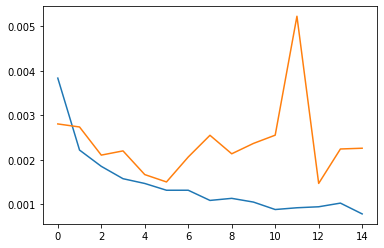

In [522]:
plt.plot(his_loss["train"])
plt.plot(his_loss["val"])

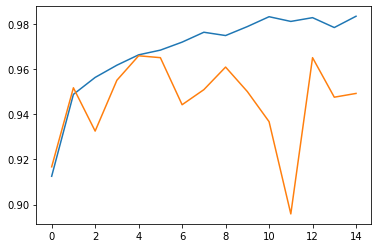

In [523]:
plt.plot(his_acc["train"])
plt.plot(his_acc["val"])

### add rotation method

In [508]:
model_rotation=CNN(0.2)
optim=torch.optim.Adam(model_rotation.parameters(),lr=lr)
loss=nn.BCEWithLogitsLoss()
import time
train_dataset=[train_pos_data,train_neg_data]
valid_dataset=[valid_pos_data,valid_neg_data]
his_loss_rotate,his_acc_rotate=train(model_rotation,1,10,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=True,name="model_rotation",early_stop=True)

4800
1200
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 221.87 sec(s) Train Acc: 0.905208 Loss: 0.004066 | Val Acc: 0.924167 loss: 0.003625
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_epoch_0
4800
1200
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 223.15 sec(s) Train Acc: 0.942917 Loss: 0.002433 | Val Acc: 0.941667 loss: 0.003171
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_epoch_1
4800
1200
finish preparing data
start training_2

finish 0 iterations
finish 10 iterations
[019/050] 214.38 sec(s) Train Acc: 0.981250 Loss: 0.000850 | Val Acc: 0.973333 loss: 0.001232
Counter 7 of 3
4800
1200
finish preparing data
start training_19_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 19 epoch.
finish 0 iterations
finish 10 iterations
[020/050] 222.67 sec(s) Train Acc: 0.977708 Loss: 0.000886 | Val Acc: 0.955833 loss: 0.001572
Counter 8 of 3
4800
1200
finish preparing data
start training_20_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 20 epoch.
finish 0 iterations
finish 10 iterations
[021/050] 217.69 sec(s) Train Acc: 0.976458 Loss: 0.001078 | Val Acc: 0.975833 loss: 0.000990
Counter 9 of 3
48

In [726]:
train_loss_02=[0.004066,0.002433,0.001984,0.001693,0.001767,0.001525,0.001526,0.001880,0.001248,0.001342,0.001435,0.001066,0.001095,0.001139,0.001264,0.001096,0.001178,0.000987,0.000850,0.000886,0.001078,0.001033,0.001008]
train_acc_02=[0.905208,0.942917,0.946875,0.957708,0.957292,0.962708,0.962708,0.962500,0.971250,0.967500,0.963750,0.975000,0.974375,0.975000,0.973333,0.973750,0.969792,0.973542,0.981250,0.977708,0.976458,0.976250,0.977292]
val_loss_02=[0.003625,0.003171,0.002778,0.001949,0.001490,0.001945,0.001810,0.001590,0.001090,0.001594,0.001556,0.000989,0.001299,0.001297,0.001208,0.001521,0.001072,0.001225,0.001232,0.001572,0.000990,0.001915,0.001077]
val_acc_02=[0.924167,0.941667,0.940833,0.960833,0.967500,0.955833,0.961667,0.960000,0.977500,0.962500,0.970000,0.980000,0.968333,0.975833,0.975833,0.976667,0.978333,0.973333,0.973333,0.955833,0.975833,0.951667,0.976667]

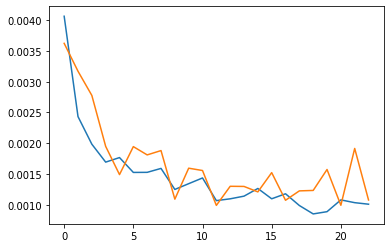

In [519]:
plt.plot(his_loss_rotate["train"])
plt.plot(his_loss_rotate["val"])

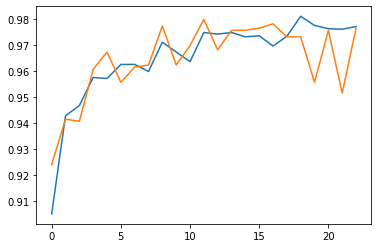

In [520]:
plt.plot(his_acc_rotate["train"])
plt.plot(his_acc_rotate["val"])                        

In [769]:
path=r'D:\CS\NTU\BS6207\project\model\model_rotation_dropout_02'
model_rotation=CNN(0.2)
model_rotation.load_state_dict(torch.load(path))

<All keys matched successfully>

In [782]:
lig_data_set['0061']

array([[50.733, 58.967, 33.611,  1.   ,  0.   , -1.   ],
       [46.266, 58.275, 35.197,  0.   ,  1.   , -1.   ],
       [45.128, 61.817, 38.22 ,  0.   ,  1.   , -1.   ],
       [47.806, 61.794, 40.916,  0.   ,  1.   , -1.   ],
       [50.722, 60.718, 37.905,  0.   ,  1.   , -1.   ]])

In [ ]:
valid_data,length_positive=create_epoch_data(valid_pos_data,valid_neg_data,pro_data_set,lig_data_set,'limit')

In [787]:
length_positive

600

In [788]:
#prediction label compared with test label, return the classification_report.
def modelPerformance(y_test,y_pred,thres):
    cm=confusion_matrix(y_test,y_pred)
    df_cm=pd.DataFrame(cm)
    sns.set(font_scale=2.0)
    sns.heatmap(df_cm, annot=True,fmt='g',cmap ='Blues')
    plt.title("threshold="+str(round(thres,4)))
    print(classification_report(y_test,y_pred))

In [951]:
def test(model,batch_size,threshold,dataset,length):
    model.eval()
    y_pred=[]
    y_true=[]
    print(length)
    print(len(dataset))
    valid_mini_data=miniDataset(dataset,length,'training',transform=transform.Compose([make_grid(),
                                                                       array2tensor(torch.FloatTensor)]),
                                          target_transform=array2tensor(torch.FloatTensor))

    valid_loader = torch.utils.data.DataLoader(dataset=valid_mini_data,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               drop_last=False)
    with torch.no_grad():
        for step,(inp,target) in enumerate(valid_loader):
            y_pred_po=model(inp)
#                     print(y_pred_po.shape)
#                     print(type(y_pred_po))
            y_true+=target.numpy().tolist()
            y_pred_po_result=(y_pred_po.detach().numpy()>threshold).reshape(-1) 
            y_pred+=y_pred_po_result.tolist()           
            if step%10==0:
                print('finish {} iterations'.format(step))
        thres=torch.sigmoid(torch.tensor([threshold]))
        modelPerformance(y_true,y_pred,float(thres.numpy()))
        

600
1200
1200
finish 0 iterations
finish 10 iterations
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       600
         1.0       0.97      0.97      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200



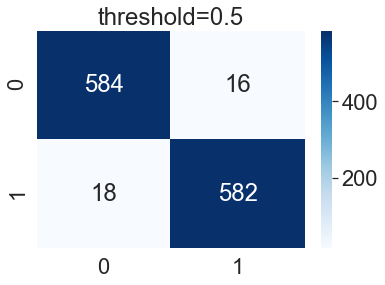

In [800]:
from collections import Counter
import seaborn as sns
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,auc,confusion_matrix,classification_report,roc_auc_score,f1_score
test(model_rotation,64,0,valid_data,length_positive)

## tune parameters

In [716]:
import time
dropouts=[0.4,0.6,0.8]
dropout_history=[]
for dropout in dropouts:
    model_rotation=CNN(dropout)
    optim=torch.optim.Adam(model_rotation.parameters(),lr=lr)
    loss=nn.BCEWithLogitsLoss()
    
    
    train_dataset=[train_pos_data,train_neg_data]
    valid_dataset=[valid_pos_data,valid_neg_data]
    name_=str(dropout).split('.')[1]
    name='model_rotation_dropout_0{}'.format(name_)
    print(name)
    his_loss_rotate,his_acc_rotate=train(model_rotation,1,10,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=True,name=name,early_stop=True)
    dropout_history.append((his_loss_rotate,his_acc_rotate,model_rotation,optim))

model_rotation_dropout_04
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 215.15 sec(s) Train Acc: 0.909792 Loss: 0.003993 | Val Acc: 0.901667 loss: 0.003954
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_dropout_04_epoch_0
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 213.31 sec(s) Train Acc: 0.938333 Loss: 0.002435 | Val Acc: 0.952500 l

finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 16 epoch.
finish 0 iterations
finish 10 iterations
[017/050] 212.57 sec(s) Train Acc: 0.978125 Loss: 0.001004 | Val Acc: 0.980000 loss: 0.001099
Counter 5 of 10
Early stopping with best_acc:  0.98 and val_acc for this epoch:  0.98 ...
model_rotation_dropout_06
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 252.68 sec(s) Train Acc: 0.905417 Loss: 0.003968 | Val Acc: 0.934167 loss: 0.003179
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_dropout_06_epoch_0
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
s

finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 2 epoch.
finish 0 iterations
finish 10 iterations
[003/050] 209.31 sec(s) Train Acc: 0.944167 Loss: 0.002376 | Val Acc: 0.946667 loss: 0.002488
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_dropout_08_epoch_2
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_3_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 3 epoch.
finish 0 iterations
finish 10 iterations
[004/050] 207.75 sec(s) Train Acc: 0.948542 Loss: 0.002144 | Val Acc: 0.963333 loss: 0.001866
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_dropout_08_epoch_3
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1

Text(0.5, 1.0, 'train stage')

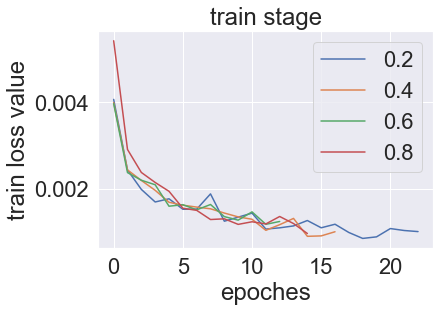

In [725]:
plt.plot(train_loss_02)
plt.plot(dropout_history[0][0]['train'])
plt.plot(dropout_history[1][0]['train'])
plt.plot(dropout_history[2][0]['train'])
plt.legend([0.2,0.4,0.6,0.8])
plt.xlabel("epoches")
plt.ylabel('train loss value')
plt.title('train stage')

Text(0.5, 1.0, 'valid stage')

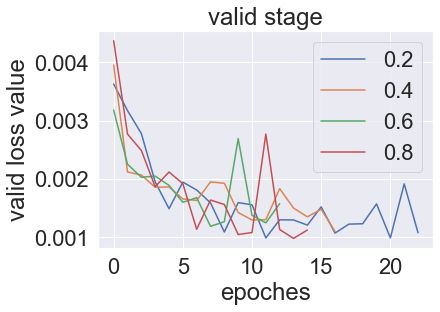

In [816]:
plt.plot(val_loss_02)
plt.plot(dropout_history[0][0]['val'])
plt.plot(dropout_history[1][0]['val'])
plt.plot(dropout_history[2][0]['val'])
plt.legend([0.2,0.4,0.6,0.8])
plt.xlabel("epoches")
plt.ylabel('valid loss value')
plt.title('valid stage')

Text(0.5, 1.0, 'train stage')

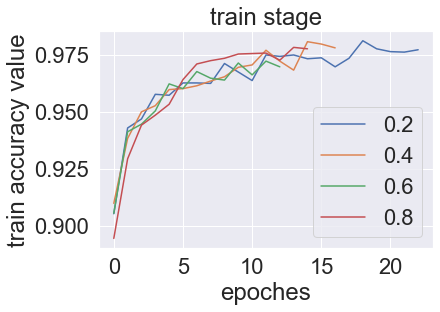

In [806]:
plt.plot(train_acc_02)
plt.plot(dropout_history[0][1]['train'])
plt.plot(dropout_history[1][1]['train'])
plt.plot(dropout_history[2][1]['train'])
plt.legend([0.2,0.4,0.6,0.8])
plt.xlabel("epoches")
plt.ylabel('train accuracy value')
plt.title('train stage')

Text(0.5, 1.0, 'valid stage')

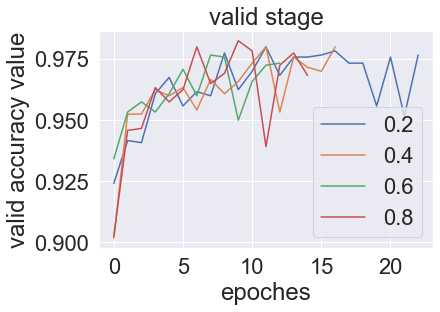

In [817]:
plt.plot(val_acc_02)
plt.plot(dropout_history[0][1]['val'])
plt.plot(dropout_history[1][1]['val'])
plt.plot(dropout_history[2][1]['val'])
plt.legend([0.2,0.4,0.6,0.8])
plt.xlabel("epoches")
plt.ylabel('valid accuracy value')
plt.title('valid stage')

* 0.8 dropout was chosen

###  learning rate 

In [737]:
import time
lrs=[0.01,0.1,0.0001]
lr_history=[]
for lr_ in lrs:
    model_rotation=CNN(0.8)
    optim=torch.optim.Adam(model_rotation.parameters(),lr=lr_)
    loss=nn.BCEWithLogitsLoss()
    
    train_dataset=[train_pos_data,train_neg_data]
    valid_dataset=[valid_pos_data,valid_neg_data]
    name_=str(lr_).split('.')[1]
    name='model_rotation_lr_{}'.format(name_)
    print(name)
    his_loss_rotate_lr,his_acc_rotate_lr=train(model_rotation,1,10,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=True,name=name,early_stop=True)
    lr_history.append((his_loss_rotate_lr,his_acc_rotate_lr,model_rotation,optim))

model_rotation_lr_1
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 247.73 sec(s) Train Acc: 0.711042 Loss: 4.637602 | Val Acc: 0.658333 loss: 0.009147
Model saved at D:\CS\NTU\BS6207\project\model\model_rotation_lr_1_epoch_0
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 249.40 sec(s) Train Acc: 0.623958 Loss: 0.009793 | Val Acc: 0.515833 loss: 0.00752

finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 10 epoch.
finish 0 iterations
finish 10 iterations
[011/050] 250.60 sec(s) Train Acc: 0.954792 Loss: 0.001905 | Val Acc: 0.963333 loss: 0.001513
Counter 3 of 5
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_11_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 11 epoch.
finish 0 iterations
finish 10 iterations
[012/050] 246.70 sec(s) Train Acc: 0.956458 Loss: 0.001788 | Val Acc: 0.961667 loss: 0.001439
Counter 4 of 5
4800
4800
4800
1
1
valid_data_length: 1200
1200
1200
1
0
finish preparing data
start training_12_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterati

Text(0.5, 1.0, 'train stage')

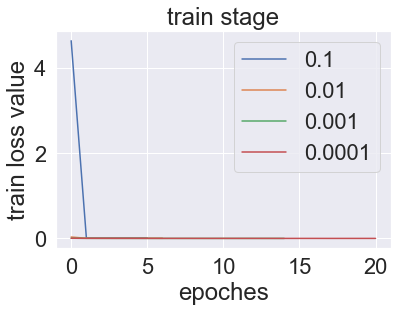

In [744]:
plt.plot(lr_history[0][0]['train'])
plt.plot(dropout_history[3][0]['train'])
plt.plot(dropout_history[2][0]['train'])
plt.plot(lr_history[1][0]['train'])
plt.legend([0.1,0.01,0.001,0.0001])
plt.xlabel("epoches")
plt.ylabel('train loss value')
plt.title('train stage')

Text(0.5, 1.0, 'validation stage')

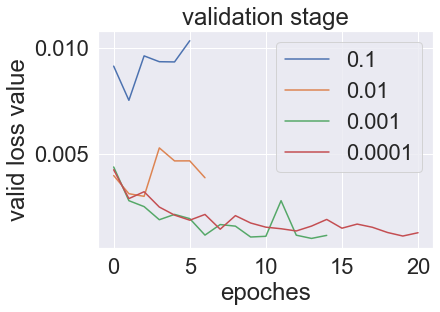

In [746]:
plt.plot(lr_history[0][0]['val'])
plt.plot(dropout_history[3][0]['val'])
plt.plot(dropout_history[2][0]['val'])
plt.plot(lr_history[1][0]['val'])
plt.legend([0.1,0.01,0.001,0.0001])
plt.xlabel("epoches")
plt.ylabel('valid loss value')
plt.title('validation stage')

Text(0.5, 1.0, 'train stage')

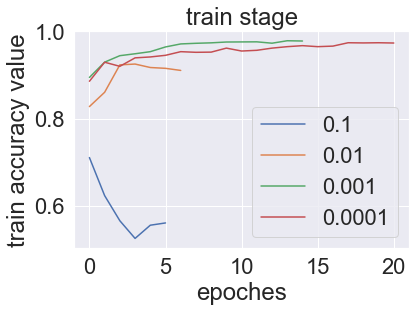

In [750]:
plt.plot(lr_history[0][1]['train'])
plt.plot(dropout_history[3][1]['train'])
plt.plot(dropout_history[2][1]['train'])
plt.plot(lr_history[1][1]['train'])
plt.legend([0.1,0.01,0.001,0.0001])
plt.xlabel("epoches")
plt.ylabel('train accuracy value')
plt.title('train stage')

Text(0.5, 1.0, 'validation stage')

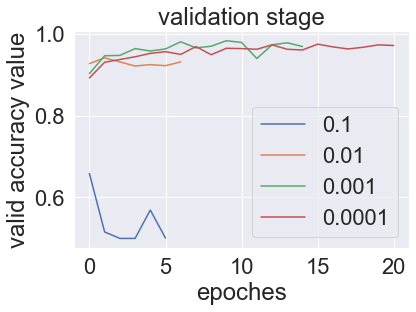

In [749]:
plt.plot(lr_history[0][1]['val'])
plt.plot(dropout_history[3][1]['val'])
plt.plot(dropout_history[2][1]['val'])
plt.plot(lr_history[1][1]['val'])
plt.legend([0.1,0.01,0.001,0.0001])
plt.xlabel("epoches")
plt.ylabel('valid accuracy value')
plt.title('validation stage')

#### GRID RESOLUTION

In [803]:
class CNN_c(nn.Module):
    def __init__(self,dropout):
        super(CNN_c, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv3d(6, 64, kernel_size=3, padding=1,stride=2),  # [64, 41,41,41]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [64, 10,10,10]

            nn.Conv3d(64, 128, kernel_size=3, padding=1,stride=1), # [128, 10, 10,10]
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [128, 5, 5,5]

            nn.Conv3d(128, 256, kernel_size=3, padding=1,stride=1), # [256, 5, 5, 5]
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2, 2, 0),      # [256, 2, 2, 2]
        )
        self.flatten=nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512,1)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = self.flatten(out)
        return self.fc(out)

## block size choose

In [804]:
model_rotation_dist=CNN_c(0.8)
optim=torch.optim.Adam(model_rotation_dist.parameters(),lr=0.001)
loss=nn.BCEWithLogitsLoss()

train_dataset=[train_pos_data,train_neg_data]
valid_dataset=[valid_pos_data,valid_neg_data]
his_loss_rotate_dist,his_acc_rotate_dist=train(model_rotation_dist,1,20,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=True,name="model_20_max",early_stop=True)

4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 245.11 sec(s) Train Acc: 0.885417 Loss: 0.006325 | Val Acc: 0.896667 loss: 0.004989
Model saved at D:\CS\NTU\BS6207\project\model\model_20_max_epoch_0
4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 242.87 sec(s) Train Acc: 0.925833 Loss: 0.003734 | Val Acc: 0.927500 loss: 0.003310
Model saved at D:\CS\NTU\BS6207\project\model\model_20_max_ep

Text(0.5, 1.0, 'train stage')

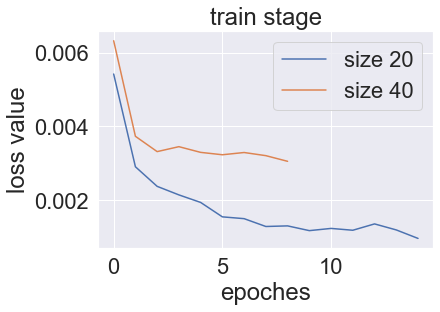

In [824]:
plt.plot(dropout_history[2][0]['train'])
plt.plot(his_loss_rotate_dist['train'])
plt.legend(['size 20','size 40'])
plt.xlabel("epoches")
plt.ylabel("loss value")
plt.title("train stage")

Text(0.5, 1.0, 'valid stage')

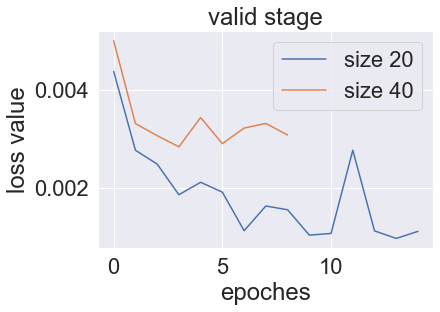

In [825]:
plt.plot(dropout_history[2][0]['val'])
plt.plot(his_loss_rotate_dist['val'])
plt.legend(['size 20','size 40'])
plt.xlabel("epoches")
plt.ylabel("loss value")
plt.title("valid stage")

Text(0.5, 1.0, 'train stage')

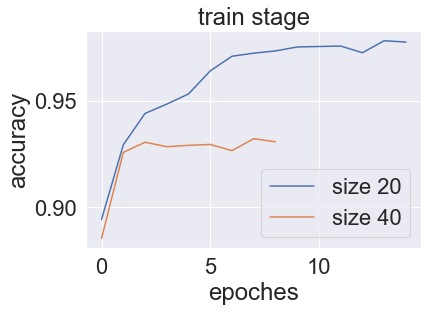

In [827]:
plt.plot(dropout_history[2][1]['train'])
plt.plot(his_acc_rotate_dist['train'])
plt.legend(['size 20','size 40'])
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title("train stage")

Text(0.5, 1.0, 'valid stage')

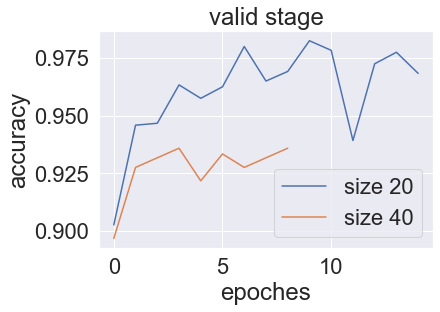

In [828]:
plt.plot(dropout_history[2][1]['val'])
plt.plot(his_acc_rotate_dist['val'])
plt.legend(['size 20','size 40'])
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title("valid stage")

In [805]:
model_rotation_re_=CNN_c(0.8)
optim=torch.optim.Adam(model_rotation_re_.parameters(),lr=0.001)
loss=nn.BCEWithLogitsLoss()

train_dataset=[train_pos_data,train_neg_data]
valid_dataset=[valid_pos_data,valid_neg_data]
his_loss_rotate_re_,his_acc_rotate_re_=train(model_rotation_re_,0.5,10,50,64,0,loss,optim,train_dataset,valid_dataset,rotation=True,name="model_05_resolution",early_stop=True)

4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_0_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 0 epoch.
finish 0 iterations
finish 10 iterations
[001/050] 237.92 sec(s) Train Acc: 0.892083 Loss: 0.005406 | Val Acc: 0.514167 loss: 0.017853
Model saved at D:\CS\NTU\BS6207\project\model\model_05_resolution_epoch_0
4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_1_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 1 epoch.
finish 0 iterations
finish 10 iterations
[002/050] 234.70 sec(s) Train Acc: 0.928750 Loss: 0.003330 | Val Acc: 0.934167 loss: 0.003853
Model saved at D:\CS\NTU\BS6207\project\model\model_05

finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 17 epoch.
finish 0 iterations
finish 10 iterations
[018/050] 235.28 sec(s) Train Acc: 0.978542 Loss: 0.001173 | Val Acc: 0.965833 loss: 0.001637
Counter 4 of 5
4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_18_epoch
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
____________________
start validation in 18 epoch.
finish 0 iterations
finish 10 iterations
[019/050] 232.70 sec(s) Train Acc: 0.975208 Loss: 0.001303 | Val Acc: 0.979167 loss: 0.001305
Model saved at D:\CS\NTU\BS6207\project\model\model_05_resolution_epoch_18
4800
4800
valid_data_length: 1200
1200
finish preparing data
start training_19_epoch
finish 0 iterations
finish 10 iterations
finish 20 ite

Text(0.5, 1.0, 'train stage')

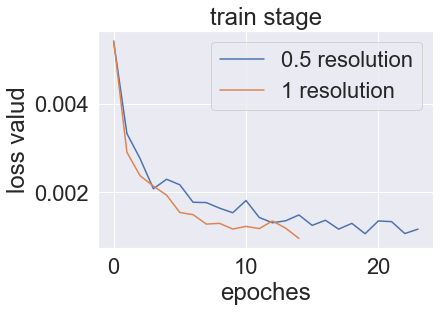

In [829]:
plt.plot(his_loss_rotate_re_['train'])
plt.plot(dropout_history[2][0]['train'])
plt.legend(["0.5 resolution",'1 resolution'])
plt.xlabel("epoches")
plt.ylabel("loss value")
plt.title("train stage")

Text(0.5, 1.0, 'valid stage')

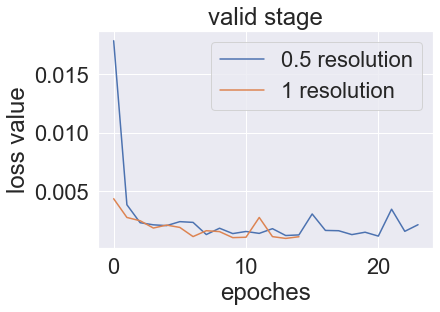

In [831]:
plt.plot(his_loss_rotate_re_['val'])
plt.plot(dropout_history[2][0]['val'])
plt.legend(["0.5 resolution",'1 resolution'])
plt.xlabel("epoches")
plt.ylabel("loss value")
plt.title("valid stage")

Text(0.5, 1.0, 'train stage')

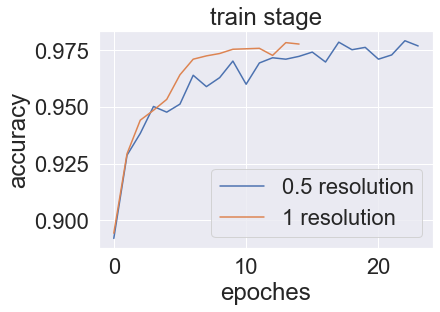

In [814]:
plt.plot(his_acc_rotate_re_['train'])
plt.plot(dropout_history[2][1]['train'])
plt.legend(["0.5 resolution",'1 resolution'])
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title("train stage")

Text(0.5, 1.0, 'valid stage')

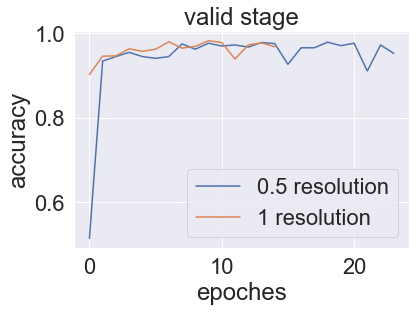

In [832]:
plt.plot(his_acc_rotate_re_['val'])
plt.plot(dropout_history[2][1]['val'])
plt.legend(["0.5 resolution",'1 resolution'])
plt.xlabel("epoches")
plt.ylabel("accuracy")
plt.title("valid stage")

## Imitation test

In [610]:
import os

In [843]:
final_model=CNN(0.8)
path=r'D:\CS\NTU\BS6207\project\model\model_rotation_dropout_08_epoch_9'
final_model.load_state_dict(torch.load(path))

<All keys matched successfully>

600

In [919]:
import random
str_num_imitation=[]

for i in range(1,3001):
    index=(4-len(str(i)))*'0'+str(i)     
    str_num_imitation.append(index)

imitation_data_set=dict()
for i in valid_pos_data:
    ii=i[0]
    samples=random.sample(str_num_imitation,824)
#     print(type(samples))
#     print(len(samples))
#     print(samples)
    if ii in samples:
        total_samples=samples
        print('contain positive')
    else:
        total_samples=random.sample(samples,823)+[ii]
        print('no positive')
    imitation_data_set[ii]=total_samples
#     imitation_data_set[i]=str_num_test

no positive
no positive
no positive
contain positive
no positive
no positive
no positive
no positive
contain positive
no positive
no positive
no positive
no positive
no positive
contain positive
no positive
contain positive
contain positive
no positive
contain positive
no positive
no positive
contain positive
no positive
no positive
contain positive
contain positive
no positive
contain positive
no positive
no positive
no positive
no positive
no positive
contain positive
contain positive
contain positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
no positive
contain positive
contain positive
contain positive
no positive
contain positive
no positive
contain positive
no positive
no positive
no positive
no positive
contain positive
no positive
no positive
no positive
no positive
no positive
contain positive
contain positive
no posi

In [920]:
for k,v in imitation_data_set.items():
    assert len(v)==824
    if k not in v:
        print('wrong')
        print(k)
        print(v)
        break

In [921]:
for k,v in imitation_data_set.items():
    imitation_data_set[k]=np.sort(v)

In [964]:
def test_for_rank(model,batch_size,dataset,length):
    model.eval()
    y_pred=[]
    print(length)
    print(len(dataset))
    valid_mini_data=miniDataset(dataset,length,'training',transform=transform.Compose([make_grid(),
                                                                       array2tensor(torch.FloatTensor)]),
                                          target_transform=array2tensor(torch.FloatTensor))

    valid_loader = torch.utils.data.DataLoader(dataset=valid_mini_data,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               drop_last=False)
    with torch.no_grad():
        for step,(inp,target) in enumerate(valid_loader):
            y_pred_po=model(inp)
#             print(y_pred_po.reshape(-1).shape)
#                     print(type(y_pred_po))
            y_pred_po=torch.sigmoid(y_pred_po.squeeze())
            y_pred.append(y_pred_po.numpy())
            if step%100==0:
                print('finish {} iterations'.format(step))
        y_pred=np.array(y_pred)
        index=np.argsort(y_pred)
        
#         index+=1
        top10=index[-10:]
#         print(y_pred[top10[-1]-1])
        return list(reversed(top10))

def get_rank(model,test_data_set,pro_test_set,lig_test_set):
    result=dict()
    
    for k,v in test_data_set.items():
        li=[]
        for vv in v:
            li.append((k,vv))
        print('length',len(li))
        data_set,length=create_epoch_data(li,None,pro_test_set,lig_test_set,strategy='limit')
        top10=test_for_rank(model,1,data_set,length)
        top10=np.array(v)[top10]
        result[k]=list(top10)
    return result

### 运行1

In [965]:
imitation_result=get_rank(final_model,imitation_data_set,pro_data_set,lig_data_set)

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

In [947]:
posive_data=[]
negative_data=[]
for k,v in imitation_data_set.items():
    posive_data.append((k,k))
    for vv in v:
        if vv!=k:
            negative_data.append((k,vv))

In [949]:
imitation_dataset_confusion,posi_length=create_epoch_data(posive_data,negative_data,pro_data_set,lig_data_set,strategy='all')

### 运行4

600
494400
494400
finish 0 iterations
finish 10 iterations
finish 20 iterations
finish 30 iterations
finish 40 iterations
finish 50 iterations
finish 60 iterations
finish 70 iterations
finish 80 iterations
finish 90 iterations
finish 100 iterations
finish 110 iterations
finish 120 iterations
finish 130 iterations
finish 140 iterations
finish 150 iterations
finish 160 iterations
finish 170 iterations
finish 180 iterations
finish 190 iterations
finish 200 iterations
finish 210 iterations
finish 220 iterations
finish 230 iterations
finish 240 iterations
finish 250 iterations
finish 260 iterations
finish 270 iterations
finish 280 iterations
finish 290 iterations
finish 300 iterations
finish 310 iterations
finish 320 iterations
finish 330 iterations
finish 340 iterations
finish 350 iterations
finish 360 iterations
finish 370 iterations
finish 380 iterations
finish 390 iterations
finish 400 iterations
finish 410 iterations
finish 420 iterations
finish 430 iterations
finish 440 iterations
fin

finish 3610 iterations
finish 3620 iterations
finish 3630 iterations
finish 3640 iterations
finish 3650 iterations
finish 3660 iterations
finish 3670 iterations
finish 3680 iterations
finish 3690 iterations
finish 3700 iterations
finish 3710 iterations
finish 3720 iterations
finish 3730 iterations
finish 3740 iterations
finish 3750 iterations
finish 3760 iterations
finish 3770 iterations
finish 3780 iterations
finish 3790 iterations
finish 3800 iterations
finish 3810 iterations
finish 3820 iterations
finish 3830 iterations
finish 3840 iterations
finish 3850 iterations
finish 3860 iterations
finish 3870 iterations
finish 3880 iterations
finish 3890 iterations
finish 3900 iterations
finish 3910 iterations
finish 3920 iterations
finish 3930 iterations
finish 3940 iterations
finish 3950 iterations
finish 3960 iterations
finish 3970 iterations
finish 3980 iterations
finish 3990 iterations
finish 4000 iterations
finish 4010 iterations
finish 4020 iterations
finish 4030 iterations
finish 4040

finish 7180 iterations
finish 7190 iterations
finish 7200 iterations
finish 7210 iterations
finish 7220 iterations
finish 7230 iterations
finish 7240 iterations
finish 7250 iterations
finish 7260 iterations
finish 7270 iterations
finish 7280 iterations
finish 7290 iterations
finish 7300 iterations
finish 7310 iterations
finish 7320 iterations
finish 7330 iterations
finish 7340 iterations
finish 7350 iterations
finish 7360 iterations
finish 7370 iterations
finish 7380 iterations
finish 7390 iterations
finish 7400 iterations
finish 7410 iterations
finish 7420 iterations
finish 7430 iterations
finish 7440 iterations
finish 7450 iterations
finish 7460 iterations
finish 7470 iterations
finish 7480 iterations
finish 7490 iterations
finish 7500 iterations
finish 7510 iterations
finish 7520 iterations
finish 7530 iterations
finish 7540 iterations
finish 7550 iterations
finish 7560 iterations
finish 7570 iterations
finish 7580 iterations
finish 7590 iterations
finish 7600 iterations
finish 7610

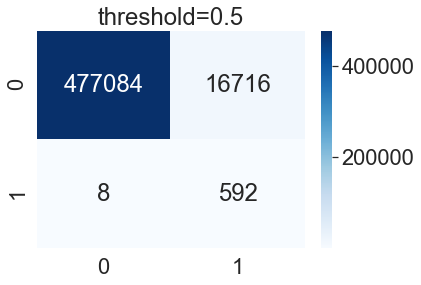

In [969]:
test(final_model,64,0,imitation_dataset_confusion,posi_length)

### success rate 

In [972]:
def cal_sr(imitation_result):
    sr=0
    length=len(imitation_result)
    for k,v in imitation_result.items():
        if k in v:
            sr+=1
    return sr/length

In [977]:
imitation_result

{'0061': ['0061',
  '0112',
  '0885',
  '0039',
  '2042',
  '1495',
  '0564',
  '2771',
  '0821',
  '1205'],
 '1400': ['1400',
  '1340',
  '1510',
  '1333',
  '0273',
  '0512',
  '0641',
  '1508',
  '0763',
  '0045'],
 '0143': ['0214',
  '0143',
  '1737',
  '0248',
  '1356',
  '1047',
  '0319',
  '0965',
  '1775',
  '1695'],
 '0783': ['0783',
  '0683',
  '0402',
  '0814',
  '0476',
  '0697',
  '2158',
  '1706',
  '0434',
  '0890'],
 '2035': ['2035',
  '2417',
  '1044',
  '0017',
  '2452',
  '0569',
  '2326',
  '0106',
  '2824',
  '1633'],
 '1359': ['1359',
  '2156',
  '2972',
  '1444',
  '0850',
  '2501',
  '1265',
  '2262',
  '1585',
  '0697'],
 '2618': ['2618',
  '1317',
  '2364',
  '0913',
  '1392',
  '0343',
  '1817',
  '1739',
  '2634',
  '1502'],
 '2819': ['1912',
  '2541',
  '2079',
  '2819',
  '2288',
  '1404',
  '2370',
  '0499',
  '1344',
  '0548'],
 '2629': ['2629',
  '2729',
  '0335',
  '1800',
  '2338',
  '0406',
  '2092',
  '0118',
  '2665',
  '2752'],
 '2277': ['2277',
 

In [974]:
cal_sr(imitation_result)

0.9533333333333334

### NDCG

In [975]:
def cal_NDCG(imitation_result):
#     length=len(imitation_result)
    ndcg=[]
    for k,v in imitation_result.items():
        length=len(v)
        idndcg=(2**1-1)/np.log2(2)
        for i in range(1,length):
            idndcg+=(2**0-1)/np.log2(i+2)

        true_ndcg=0
        for i in range(length):
            if k==v[i]:
                true_ndcg+=(2**1-1)/np.log2(i+2)
            else:
                true_ndcg+=(2**0-1)/np.log2(i+2)
        ndcg.append(true_ndcg/idndcg)
    return np.mean(ndcg)

In [976]:
cal_NDCG(imitation_result)

0.7762116783681281

## test

In [635]:
str_num_test=[]
for i in range(1,825):
    index=(4-len(str(i)))*'0'+str(i)     
    str_num_test.append(index)

test_data_set=dict()
for i in str_num_test:
        test_data_set[i]=str_num_test
    

In [624]:
def read_pdb_test(filename):

    with open(filename, 'r') as file:
        strline_L = file.readlines()
        # print(strline_L)

    X_list = list()
    Y_list = list()
    Z_list = list()
    atomtype_list = list()
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()
        
        splitted_line = stripped_line.split('\t')
#         print(splitted_line)
#         print(type(splitted_line[0]))
        
#         print(splitted_line[0])
#         print(str(splitted_line[0]).strip())
#         print(splitted_line)
#         print(str(splitted_line[3]))
        
        X_list.append(float(str(splitted_line[0].strip())))
        Y_list.append(float(str(splitted_line[1].strip())))
        Z_list.append(float(str(splitted_line[2].strip())))

        atomtype = str(splitted_line[3])
        atomtype_list.append(atomtype) 

    return X_list, Y_list, Z_list, atomtype_list

In [628]:
#lig-dataset
lig_test_set=dict()
for i in str_num_test:
    path=r'D:\CS\NTU\BS6207\project\testing_data_release\testing_data\{}_lig_cg.pdb'.format(i)
    X,Y,Z,atom_types=read_pdb_test(path)
#     print(atom_types)
    one_image=[]
    for x,y,z,atom_type in zip(X,Y,Z,atom_types):
        if atom_type=='p':
            pixel=np.array([x,y,z,1,0,-1])
        else:
            pixel=np.array([x,y,z,0,1,-1])
        one_image.append(pixel)
    lig_test_set[i]=np.stack(one_image,axis=0)

In [633]:
#pro-dataset
pro_test_set=dict()
for i in str_num_test:
    path=r'D:\CS\NTU\BS6207\project\testing_data_release\testing_data\{}_pro_cg.pdb'.format(i)
    X,Y,Z,atom_types=read_pdb_test(path)
#     print(atom_types)
    one_image=[]
    for x,y,z,atom_type in zip(X,Y,Z,atom_types):
        if atom_type=='p':
            pixel=np.array([x,y,z,1,0,1])
        else:
            pixel=np.array([x,y,z,0,1,1])
        one_image.append(pixel)
    pro_test_set[i]=np.stack(one_image,axis=0)

### test_set

In [966]:
def test_for_rank(model,batch_size,dataset,length):
    model.eval()
    y_pred=[]
    print(length)
    print(len(dataset))
    valid_mini_data=miniDataset(dataset,length,'training',transform=transform.Compose([make_grid(),
                                                                       array2tensor(torch.FloatTensor)]),
                                          target_transform=array2tensor(torch.FloatTensor))

    valid_loader = torch.utils.data.DataLoader(dataset=valid_mini_data,
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               drop_last=False)
    with torch.no_grad():
        for step,(inp,target) in enumerate(valid_loader):
            y_pred_po=model(inp)
#             print(y_pred_po.reshape(-1).shape)
#                     print(type(y_pred_po))
            y_pred_po=torch.sigmoid(y_pred_po.squeeze())
            y_pred.append(y_pred_po.numpy())
            if step%100==0:
                print('finish {} iterations'.format(step))
        y_pred=np.array(y_pred)
        index=np.argsort(y_pred)
        
#         index+=1
        top10=index[-10:]
#         print(y_pred[top10[-1]-1])
        return list(reversed(top10))

def get_rank(model,test_data_set,pro_test_set,lig_test_set):
    result=dict()
    step_=0
    for k,v in test_data_set.items():
        li=[]
        for vv in v:
            li.append((k,vv))
        print('length',len(li))
        data_set,length=create_epoch_data(li,None,pro_test_set,lig_test_set,strategy='limit')
        top10=test_for_rank(model,1,data_set,length)
        top10=np.array(v)[top10]
        result[k]=list(top10)
        print(step_)
        step_+=1
    return result

### 运行2

In [967]:
result=get_rank(final_model,test_data_set,pro_test_set,lig_test_set)

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iter

finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824
824
824
finish 0 iterations
finish 100 iterations
finish 200 iterations
finish 300 iterations
finish 400 iterations
finish 500 iterations
finish 600 iterations
finish 700 iterations
finish 800 iterations
length 824
824

In [979]:
def change_str_to_int(result):
    for k, v in result.items():
        vv=[]
        for vvv in v:
            vv.append(int(vvv))
        result[k]=vv
    return result

In [982]:
result_2=change_str_to_int(result)

In [957]:
# {'0001': [213, 144, 278, 210, 95, 665, 227, 365, 630, 366]}

{'0001': [213, 144, 278, 210, 95, 665, 227, 365, 630, 366]}

### export file

In [958]:
import os

def save_pickle(a, path):
    with open(path, 'wb') as f:
        pickle.dump(a, f)


def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    

In [959]:
file_name=r'./test_predictions.txt'
def export_dict(dict_files,path):
    with open(path,'w') as f:
        f.write('pro_id'+'\t')
        for i in range(1,11):
            name='lig{}_id'.format(i)
            if i!=10:
                f.write(name+'\t')
            else:
                f.write(name+'\n')
        for i in range(1,825):
            pro_name=(4-len(str(i)))*'0'+str(i)
            f.write(str(i)+'\t')
            for j in range(len(dict_files[pro_name])):
                num=dict_files[pro_name][j]
                if(j==9):
                    f.write(str(num)+'\n')
                else:
                    f.write(str(num)+'\t')

### 运行3

In [983]:
export_dict(result,file_name)